In [11]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [165]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
SHORT_SIZE = 10000
x_train_mnist = x_train_mnist[:SHORT_SIZE]
y_train_mnist = y_train_mnist[:SHORT_SIZE]
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 28, 28, 1)
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
x_train_mnist = x_train_mnist.astype('float32')
x_test_mnist = x_test_mnist.astype('float32')
x_train_mnist /= 255
x_test_mnist /= 255

bankdata = pd.read_csv("bill_authentication.csv")
x_bill = bankdata.drop('Class', axis=1)
y_bill = bankdata['Class']
x_train_bill, x_test_bill, y_train_bill, y_test_bill = train_test_split(x_bill, y_bill, test_size = 0.20)

iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_colnames = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
irisdata = pd.read_csv(iris_url, names=iris_colnames)
x_iris = irisdata.drop('Class', axis=1)
y_iris = irisdata['Class']
x_train_iris, x_test_iris, y_train_iris, y_test_iris = train_test_split(x_iris, y_iris, test_size = 0.20)

In [150]:
mnist_input_shape = (28, 28, 1)
def create_sequential_model():
    model = Sequential()
    model.add(Conv2D(28, kernel_size=(3,3), input_shape=mnist_input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dropout(0.2))
    model.add(Dense(10,activation=tf.nn.softmax))
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
    return model

def create_linear_svc_model():
    return SVC(kernel='linear',probability=True)

def create_rbf_svc_model():
    return SVC(kernel='rbf',probability=True,gamma='auto')

In [151]:
def query_default(model, x_train, labeled, batch_size, reshape_f):
    res = []
    for i in range(len(x_train)):
        if not labeled[i]:
            res += [i]
        if len(res) == batch_size:
            return res
    return res

def f1(p):
    return max(p)

def f2(p):
    return sorted(p)[-1] - sorted(p)[-2]

def f_entropy(p):
    return sum([e * math.log((e + math.pow(10, -10))) for e in p])

img_rows = img_cols = 28

def reshape_mnist(x):
    return x.reshape(1, img_rows, img_cols, 1)

def reshape_svc(x):
    return x.reshape(1, -1)

def query_uncert(model, x_train, labeled, batch_size, uncert_f, reshape_f):
    pre_batch = []
    for i in range(len(x_train)):
        if not labeled[i]:
            p = model.predict_proba(reshape_f(x_train[i]))
            pre_batch.append((uncert_f(p.flatten()), i))
    return [i for (p, i) in sorted(pre_batch)[:batch_size]]

def query_uncert_1(model, x_train, labeled, batch_size, reshape_f):
    return query_uncert(model, x_train, labeled, batch_size, f1, reshape_f)

def query_uncert_2(model, x_train, labeled, batch_size, reshape_f):
    return query_uncert(model, x_train, labeled, batch_size, f2, reshape_f)

def query_entropy(model, x_train, labeled, batch_size, reshape_f):
    return query_uncert(model, x_train, labeled, batch_size, f_entropy, reshape_f)

def score_sequential(model, x_test, y_test):
    return model.evaluate(x_test, y_test, verbose=0)[1]

def score_svc(model, x_test, y_test):
    return model.score(x_test, y_test)

In [152]:
def run_AL(
    query_f, 
    create_model, 
    reshape_f,
    score_f,
    x_train, y_train, x_test, y_test, 
    init_size, batch_size, query_number
):
    model = create_model()
    x_train_labeled = x_train[:init_size]
    y_train_labeled = y_train[:init_size]
    labeled = [True if i < init_size else False for i in range(x_train.shape[0])]
    model.fit(x_train_labeled, y_train_labeled)
    acc_growth = [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    for i in range(query_number):
        query = query_f(model, x_train, labeled, batch_size, reshape_f)
        for i in query:
            x_train_labeled = np.append(x_train_labeled, [x_train[i]], axis = 0)
            y_train_labeled = np.append(y_train_labeled, [y_train[i]], axis = 0)
            labeled[i] = True
        model.fit(x_train_labeled, y_train_labeled)
        acc_growth += [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    return acc_growth

In [172]:
random_iris = run_AL(query_default, create_rbf_svc_model, reshape_svc, score_svc, 
                    x_train_iris.to_numpy(), 
                    y_train_iris.to_numpy(), 
                    x_test_iris.to_numpy(), 
                    y_test_iris.to_numpy(),
                    3, 1, 50)
entropy_iris = run_AL(query_entropy, create_rbf_svc_model, reshape_svc, score_svc, 
                    x_train_iris.to_numpy(), 
                    y_train_iris.to_numpy(), 
                    x_test_iris.to_numpy(), 
                    y_test_iris.to_numpy(),
                    3, 1, 50)

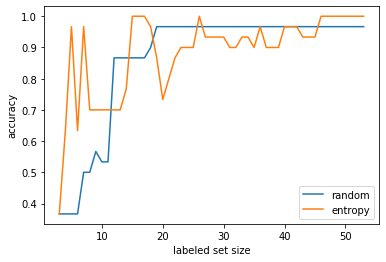

In [173]:
xs_random = [e[0] for e in random_iris]
ys_random = [e[1] for e in random_iris]
xs_entropy = [e[0] for e in entropy_iris]
ys_entropy = [e[1] for e in entropy_iris]
plt.plot(xs_random, ys_random, label='random')
plt.plot(xs_entropy, ys_entropy, label='entropy')
plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [155]:
random_bill = run_AL(query_default, create_linear_svc_model, reshape_svc, score_svc, 
                    x_train_bill.to_numpy(), 
                    y_train_bill.to_numpy(), 
                    x_test_bill.to_numpy(), 
                    y_test_bill.to_numpy(),
                    5, 1, 35)
entropy_bill = run_AL(query_entropy, create_linear_svc_model, reshape_svc, score_svc, 
                    x_train_bill.to_numpy(), 
                    y_train_bill.to_numpy(), 
                    x_test_bill.to_numpy(), 
                    y_test_bill.to_numpy(),
                    5, 1, 35)

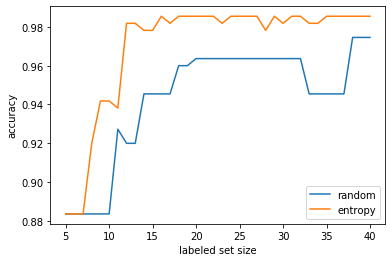

In [156]:
xs_random = [e[0] for e in random_bill]
ys_random = [e[1] for e in random_bill]
xs_entropy = [e[0] for e in entropy_bill]
ys_entropy = [e[1] for e in entropy_bill]
plt.plot(xs_random, ys_random, label='random')
plt.plot(xs_entropy, ys_entropy, label='entropy')
plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
random_mnist = run_AL(query_default, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    2000, 1, 100)
entropy_mnist = run_AL(query_entropy, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    2000, 1, 100)

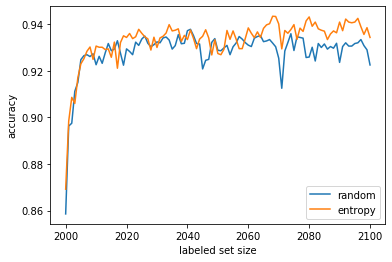

In [146]:
xs_random = [e[0] for e in random_mnist]
ys_random = [e[1] for e in random_mnist]
xs_entropy = [e[0] for e in entropy_mnist]
ys_entropy = [e[1] for e in entropy_mnist]
plt.plot(xs_random, ys_random, label='random')
plt.plot(xs_entropy, ys_entropy, label='entropy')
plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
seq_statistic = []
seq_statistic.append(('random', 2000, random_mnist))
seq_statistic.append(('entropy', 2000, entropy_mnist))
for init_size in [500, 1000, 3000, 5000]:
    seq_statistic.append(('random', init_size, run_AL(query_default, create_sequential_model, reshape_mnist, score_sequential, 
                                                x_train_mnist, 
                                                y_train_mnist, 
                                                x_test_mnist, 
                                                y_test_mnist,
                                                init_size, 1, 100)))
    seq_statistic.append(('entropy', init_size, run_AL(query_default, create_sequential_model, reshape_mnist, score_sequential, 
                                                x_train_mnist, 
                                                y_train_mnist, 
                                                x_test_mnist, 
                                                y_test_mnist,
                                                init_size, 1, 100)))

In [175]:
import pickle

with open('seq_statistic.pkl', 'wb') as f:
    pickle.dump(seq_statistic, f)

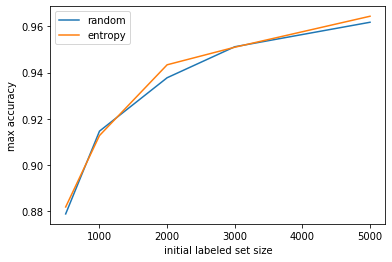

In [177]:
xs_random = [s[1] for s in sorted([s for s in seq_statistic if s[0] == 'random'], key=lambda s:s[1])]
ys_random = [max([pair[1] for pair in s[2]]) for s in sorted([s for s in seq_statistic if s[0] == 'random'], key=lambda x:x[1])]
xs_entropy = [s[1] for s in sorted([s for s in seq_statistic if s[0] == 'entropy'], key=lambda s:s[1])]
ys_entropy = [max([pair[1] for pair in s[2]]) for s in sorted([s for s in seq_statistic if s[0] == 'entropy'], key=lambda x:x[1])]
plt.plot(xs_random, ys_random, label='random')
plt.plot(xs_entropy, ys_entropy, label='entropy')
plt.xlabel('initial labeled set size')
plt.ylabel('max accuracy')
plt.legend()
plt.show()